# Fine-Grained Dog Breed Classification: A Deep Learning Approach

## Project Introduction

### What This Project Is About

This project tackles the problem of **fine-grained image classification** using **Convolutional Neural Networks (CNNs)**. Specifically, I will build a deep learning model to classify images of dogs into their specific breeds. This is a **multi-class classification problem** with 120 different dog breed categories.

The architecture approach will utilize **transfer learning with pre-trained CNN models** trained on ImageNet. I will implement and compare multiple architectures:

1. **Transfer Learning Approach**: Use pre-trained models (ResNet50, VGG16, or EfficientNetB0) as feature extractors, freeze the convolutional base, and train only the new fully connected classification layers on the dog breed dataset
2. **Fine-Tuning Approach**: Start with pre-trained weights, then unfreeze some of the top convolutional layers and fine-tune them along with the classification layers using a low learning rate
3. **Custom CNN Architecture**: Build a CNN from scratch with multiple convolutional blocks (Conv2D + BatchNormalization + MaxPooling + Dropout) to serve as a baseline for comparison

I will compare these approaches to determine which strategy yields the best performance for this specific classification task.

### Goal and Motivation

**Goal**: To develop an accurate deep learning classifier that can identify dog breeds from images with high precision, and to understand which architectural approach works best for fine-grained visual recognition.

**Why This Matters**:

- **Practical Application**: Automated breed identification can help in animal shelters, veterinary clinics, and pet adoption services where quick and accurate breed identification is essential
- **Lost Pet Recovery**: Can assist in matching found dogs with lost pet reports
- **Education**: Helps dog enthusiasts and potential pet owners learn about different breeds
- **Technical Challenge**: Dog breed classification is a challenging fine-grained visual recognition problem because many breeds share similar physical characteristics (facial features, body shape, coat patterns), making it an excellent testbed for evaluating deep learning techniques and transfer learning strategies

**What I Want to Achieve**:

- Build a model that can accurately distinguish between 120 dog breeds, even when breeds look visually similar (e.g., Siberian Husky vs. Alaskan Malamute)
- Compare the effectiveness of transfer learning versus training from scratch
- Understand which visual features the model uses to make distinctions through visualization techniques (such as class activation maps)
- Achieve practical accuracy that could be deployed in real-world applications

_______

**Expected Outcomes**: A trained CNN model with >80% accuracy on the test set, comprehensive comparison of different architectures, and insights into what makes certain breeds easier or harder to classify.

### Hardware Requirements & Cost Considerations

Deep learning for image classification is **compute-intensive** and requires GPU acceleration for practical training times.

#### Hardware Requirements

**GPU (Essential)**:
- **Minimum**: NVIDIA GPU with 8GB+ VRAM
- **Recommended**: 16GB+ VRAM (A40, A100, RTX 3090/4090)
- Training on CPU would take 50-100× longer (days instead of hours)

#### Training Costs (RunPod Cloud GPU)

**Current Setup**: 1× NVIDIA A40 (46GB)

| Training Stage | Time | Cost |
|----------------|------|------|
| Frozen baseline (completed) | 48 min | $0.32 |
| Fine-tuning unfrozen (next) | 3-5 hours | $1.50-2.00 |
| Full project | 5-10 hours | $2-5 |

**GPU Upgrade Options**:
- **A40**: $0.40-0.60/hour (current, baseline performance)
- **H100**: $2.50-4.00/hour (3-4× faster - good for rapid iteration)
- **2× A40**: $0.80-1.20/hour (parallel training - good for testing multiple models)

## Data Loading & Initial Inspection

### Dataset: Stanford Dogs

**Source**: Stanford Dogs Dataset  
**URL**: http://vision.stanford.edu/aditya86/ImageNetDogs/  
**License**: Academic/Research use  
**Size**: ~750MB (images), 20,580 total images

**Dataset Description**:

The Stanford Dogs dataset contains images of 120 breeds of dogs from around the world. This dataset has been built using images and annotation from ImageNet for the task of fine-grained image categorization.

**Key Statistics**:

- **120 dog breed classes** (Chihuahua, Afghan_hound, Maltese_dog, Golden_retriever, etc.)
- **20,580 images total** (after validation)
- **Average 171.5 images per breed** (range: 148-252)
- **Average image dimensions**: 443×386 pixels
- **Image format**: JPEG (20,579 images), PNG (1 image)
- **Color mode**: RGB (20,579 images), RGBA (1 image)

**Data Organization**:

Images are organized in directories by breed:
```
data/raw/Images/
├── n02085620-Chihuahua/
├── n02085782-Japanese_spaniel/
├── n02085936-Maltese_dog/
└── ... (120 breed directories total)
```

**Preprocessing Pipeline**:

1. **Download** (`python -m dbc.ingest`): Downloaded images, annotations, and breed mapping
2. **Validation** (`python -m dbc.preprocess`): Scanned all 20,580 images, validated for corruption, size, and format
3. **Cleaning**: Removed 0 corrupt images, all images passed validation ✓
4. **Splitting**: Created stratified 80/20 train/validation split
   - Train: 16,508 images
   - Validation: 4,072 images

**Why This Dataset?**:

- **Fine-grained classification challenge**: Many breeds share similar visual features, making this an excellent test for CNN architectures
- **Sufficient data**: ~170 images per class enables meaningful training with data augmentation
- **Real-world applicability**: Breed identification has practical uses in animal shelters, veterinary clinics, and pet services

**Dataset Challenges**:

This dataset presents several real-world complications that make classification more challenging:

- **Multiple Objects**: Many images contain humans, other animals, or various background objects alongside the dogs
- **Variable Composition**: Dogs may occupy only a small portion of the image frame
- **Background Clutter**: Complex backgrounds with furniture, outdoor scenery, or other distractions
- **Occlusion**: Dogs may be partially hidden or cropped in some images

These challenges make the task more realistic and require the model to learn discriminative breed features despite visual noise.

In [2]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent / "src"))

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import display
import json

# Load breed mapping
breeds_df = pd.read_csv("../data/raw/breed_mapping.csv")
print("Breed Mapping (first 10 breeds):")
display(breeds_df.head(10))

# Load train/val metadata
train_df = pd.read_csv("../artifacts/train_metadata.csv")
val_df = pd.read_csv("../artifacts/val_metadata.csv")

print(f"\nTrain set: {len(train_df)} images")
print(f"Validation set: {len(val_df)} images")

# Load dataset statistics
with open("../artifacts/dataset_stats.json", "r") as f:
    stats = json.load(f)
    
print("\nDataset Statistics:")
for key, value in stats.items():
    if key not in ['image_modes', 'image_formats']:
        print(f"  {key}: {value}")
        
print("\nTrain metadata (first 5 samples):")
display(train_df[['breed_name', 'class_id', 'width', 'height', 'filename']].head())

Breed Mapping (first 10 breeds):


class_id           breed_name                      breed_dir
0         1            Chihuahua            n02085620-Chihuahua
1         2     Japanese_spaniel     n02085782-Japanese_spaniel
2         3          Maltese_dog          n02085936-Maltese_dog
3         4             Pekinese             n02086079-Pekinese
4         5             Shih-Tzu             n02086240-Shih-Tzu
5         6     Blenheim_spaniel     n02086646-Blenheim_spaniel
6         7             papillon             n02086910-papillon
7         8          toy_terrier          n02087046-toy_terrier
8         9  Rhodesian_ridgeback  n02087394-Rhodesian_ridgeback
9        10         Afghan_hound         n02088094-Afghan_hound


Train set: 16508 images
Validation set: 4072 images

Dataset Statistics:
  total_images: 20580
  total_breeds: 120
  avg_images_per_breed: 171.5
  min_images_per_breed: 148
  max_images_per_breed: 252
  avg_width: 442.5318756073858
  avg_height: 385.8612244897959
  avg_size_kb: 36.90375502042335

Train metadata (first 5 samples):


breed_name  class_id  width  height            filename
0  Afghan_hound        10    489     500   n02088094_294.jpg
1  Afghan_hound        10    500     375   n02088094_173.jpg
2  Afghan_hound        10    459     500  n02088094_4635.jpg
3  Afghan_hound        10    340     500   n02088094_515.jpg
4  Afghan_hound        10    500     333  n02088094_4072.jpg

## Preprocess

### Data Cleaning

Before training our CNN model, we need to ensure our dataset is clean and ready. This section analyzes the raw scanned data and applies quality filters to remove problematic images.

**Cleaning Checks Performed:**

1. **Corrupt Image Detection** - Identify images that cannot be loaded or have invalid pixel data
2. **Duplicate Removal** - Find and remove duplicate filenames to prevent data leakage
3. **Size Validation** - Filter out images that are too small (<50×50px) or too large (>10MB)
4. **Color Mode Analysis** - Check for grayscale/RGBA images that need RGB conversion
5. **Aspect Ratio Check** - Flag extreme aspect ratios that may cause issues during resizing

**Why This Matters:**

- **Prevents training crashes** - Ensures all images can be loaded successfully
- **Improves data quality** - Removes low-quality or problematic images
- **Avoids data leakage** - Duplicate removal prevents the same image appearing in train and validation
- **Informs preprocessing** - Understanding color modes and aspect ratios helps design the data pipeline

In [3]:
# Load the raw scan results to show cleaning process
scan_df = pd.read_csv("../artifacts/dataset_scan.csv")

print("Data Cleaning Pipeline")
print("="*60)

# Step 1: Check for invalid/corrupt images
invalid_images = scan_df[scan_df['valid'] == False]
print(f"\n1. Invalid/Corrupt Images: {len(invalid_images)}")
if len(invalid_images) > 0:
    print("   Errors found:")
    for _, row in invalid_images.head(5).iterrows():
        print(f"     - {row['filename']}: {row['error']}")
else:
    print("   ✓ No corrupt images detected")

# Step 2: Check for duplicates
duplicates = scan_df[scan_df.duplicated(subset=['filename'], keep=False)]
print(f"\n2. Duplicate Files: {len(duplicates)}")
if len(duplicates) > 0:
    print(f"   Found {len(duplicates)} duplicate filenames")
else:
    print("   ✓ No duplicates found")

# Step 3: Size violations
size_violations = scan_df[
    (scan_df['width'] < 50) | 
    (scan_df['height'] < 50) | 
    (scan_df['size_kb'] > 10000)
]
print(f"\n3. Size Violations: {len(size_violations)}")
print(f"   - Too small (<50px): {len(scan_df[(scan_df['width'] < 50) | (scan_df['height'] < 50)])}")
print(f"   - Too large (>10MB): {len(scan_df[scan_df['size_kb'] > 10000])}")
if len(size_violations) == 0:
    print("   ✓ All images meet size requirements")

# Step 4: Color mode check
print(f"\n4. Color Modes:")
color_modes = scan_df['mode'].value_counts()
for mode, count in color_modes.items():
    print(f"   - {mode}: {count} images")
non_rgb = scan_df[scan_df['mode'] != 'RGB']
print(f"   Note: {len(non_rgb)} non-RGB images will be converted during training")

Data Cleaning Pipeline

1. Invalid/Corrupt Images: 0
   ✓ No corrupt images detected

2. Duplicate Files: 0
   ✓ No duplicates found

3. Size Violations: 0
   - Too small (<50px): 0
   - Too large (>10MB): 0
   ✓ All images meet size requirements

4. Color Modes:
   - RGB: 20579 images
   - RGBA: 1 images
   Note: 1 non-RGB images will be converted during training


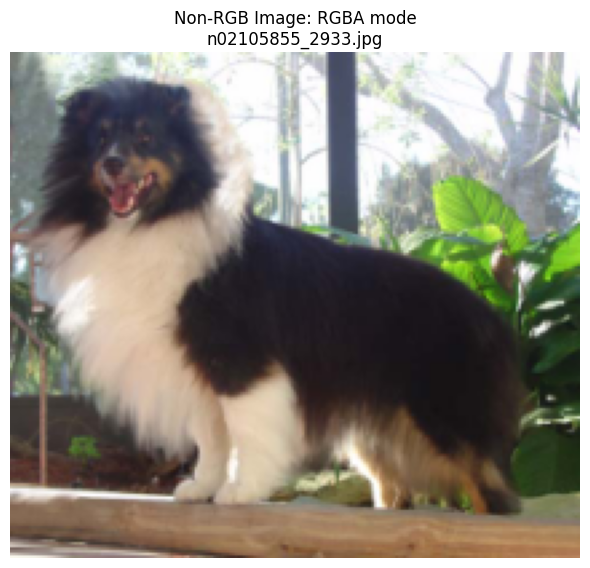


   Decision: The 1 RGBA image will be automatically converted to RGB
   during data loading (see data_loader.py). No manual fixing needed.
   This is better than modifying raw data files.


In [4]:
# Show the one non-RGB image
if len(non_rgb) > 0:
    img_path = Path("..") / non_rgb.iloc[0]['absolute_path']
    img = Image.open(img_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Non-RGB Image: {non_rgb.iloc[0]['mode']} mode\n{non_rgb.iloc[0]['filename']}")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    print(f"\n   Decision: The 1 RGBA image will be automatically converted to RGB")
    print(f"   during data loading (see data_loader.py). No manual fixing needed.")
    print(f"   This is better than modifying raw data files.")

In [5]:
# Step 5: Extreme aspect ratios
scan_df['aspect_ratio'] = scan_df['width'] / scan_df['height']
extreme_ratios = scan_df[
    (scan_df['aspect_ratio'] < 0.2) | 
    (scan_df['aspect_ratio'] > 5.0)
]
print(f"\n5. Extreme Aspect Ratios (<0.2 or >5.0): {len(extreme_ratios)}")
if len(extreme_ratios) > 0:
    print("   Images with unusual ratios (may need special handling):")
    for _, row in extreme_ratios.head(3).iterrows():
        print(f"     - {row['filename']}: {row['aspect_ratio']:.2f}")

# Final summary
print("\n" + "="*60)
print("CLEANING SUMMARY")
print("="*60)
clean_count = len(scan_df[scan_df['valid'] == True])
removed = len(scan_df) - clean_count
print(f"Initial images:    {len(scan_df)}")
print(f"Removed:           {removed}")
print(f"Clean images:      {clean_count}")
print(f"Removal rate:      {removed/len(scan_df)*100:.2f}%")
print("\n✓ Dataset is clean and ready for training!")


5. Extreme Aspect Ratios (<0.2 or >5.0): 0

CLEANING SUMMARY
Initial images:    20580
Removed:           0
Clean images:      20580
Removal rate:      0.00%

✓ Dataset is clean and ready for training!


### Cleaning Results Summary

**Perfect Dataset Quality** - All 20,580 images passed validation with zero issues:

- **0 corrupt images** - All files load successfully
- **0 duplicates** - No data leakage risk  
- **0 size violations** - All images meet dimension and file size requirements
- **1 RGBA image** - Will be auto-converted to RGB during loading

**Label Indexing Fix Applied**:

The breed mapping assigns `class_id` values from 1-120 (human-readable format), but Keras neural networks require 0-indexed labels (0-119). This is handled automatically in the data loading pipeline:

- **Source data**: `breed_mapping.csv` has `class_id` = 1-120
- **Training pipeline**: `data_loader.py` subtracts 1 to convert to 0-119
- **Implementation**: See `data_loader.py:106` - `return img_array, row['class_id'] - 1, breed_name`

This ensures compatibility with Keras while keeping human-readable breed mappings in the raw data.

**Conclusion:** The dataset is exceptionally clean and ready for the data loading pipeline.

## Exploratory Data Analysis

In this section, we explore the dataset characteristics to understand:

1. **Sample images**: Visual inspection of different breeds
2. **Class distribution**: How balanced are the 120 breed classes?
3. **Image dimensions**: Variation in image sizes and aspect ratios
4. **Data quality**: Any patterns or issues to address before training

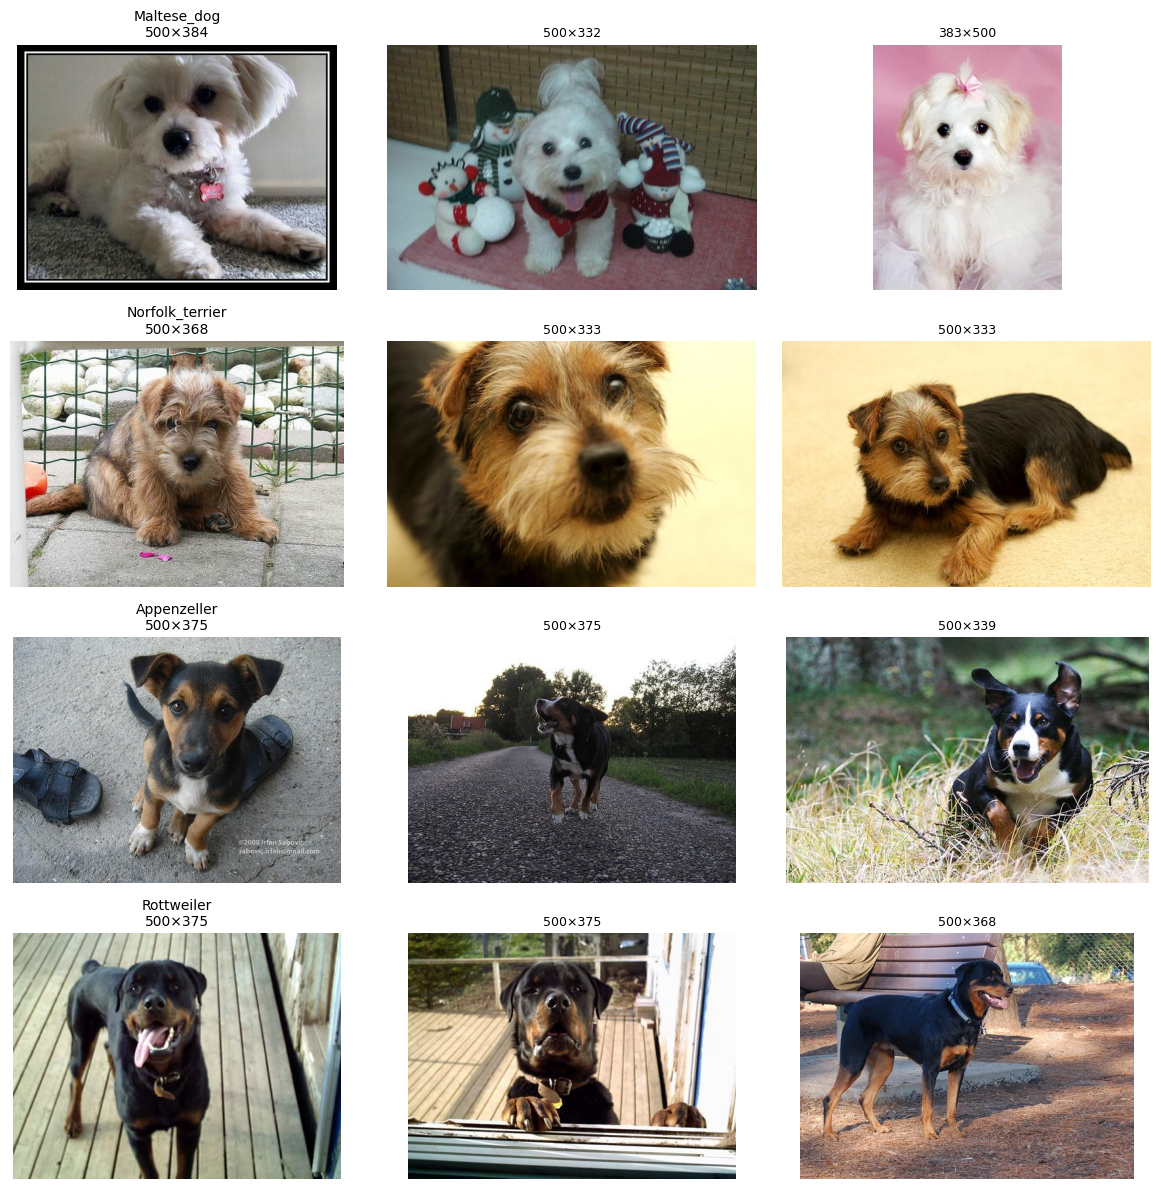


Sample images showing variety in:
  - Breed appearance (different sizes, coat colors, facial features)
  - Image dimensions (various aspect ratios and resolutions)
  - Photography conditions (backgrounds, lighting, angles)


In [6]:
# Visualize sample images from different breeds
def show_sample_images(train_df, n_breeds=4, images_per_breed=3):
    """Display sample images from random breeds"""
    
    # Sample random breeds
    breeds = train_df['breed_name'].unique()
    sample_breeds = np.random.choice(breeds, size=min(n_breeds, len(breeds)), replace=False)
    
    fig, axes = plt.subplots(n_breeds, images_per_breed, figsize=(12, n_breeds*3))
    
    for i, breed in enumerate(sample_breeds):
        breed_images = train_df[train_df['breed_name'] == breed].sample(n=images_per_breed)
        
        for j, (_, row) in enumerate(breed_images.iterrows()):
            # Use absolute_path which has full path from project root
            img_path = Path("..") / "data" / "raw" / row['file_path']
            img = Image.open(img_path)
            
            ax = axes[i, j] if n_breeds > 1 else axes[j]
            ax.imshow(img)
            ax.axis('off')
            
            if j == 0:
                ax.set_title(f"{breed}\n{img.size[0]}×{img.size[1]}", fontsize=10)
            else:
                ax.set_title(f"{img.size[0]}×{img.size[1]}", fontsize=9)
    
    plt.tight_layout()
    plt.savefig("../artifacts/figures/sample_images.png", dpi=150, bbox_inches='tight')
    plt.show()

# Create figures directory
Path("../artifacts/figures").mkdir(parents=True, exist_ok=True)

# Show samples
np.random.seed(42)
show_sample_images(train_df, n_breeds=4, images_per_breed=3)

print("\nSample images showing variety in:")
print("  - Breed appearance (different sizes, coat colors, facial features)")
print("  - Image dimensions (various aspect ratios and resolutions)")
print("  - Photography conditions (backgrounds, lighting, angles)")

### Image Dimension Analysis

Understanding image sizes helps us choose appropriate preprocessing strategies

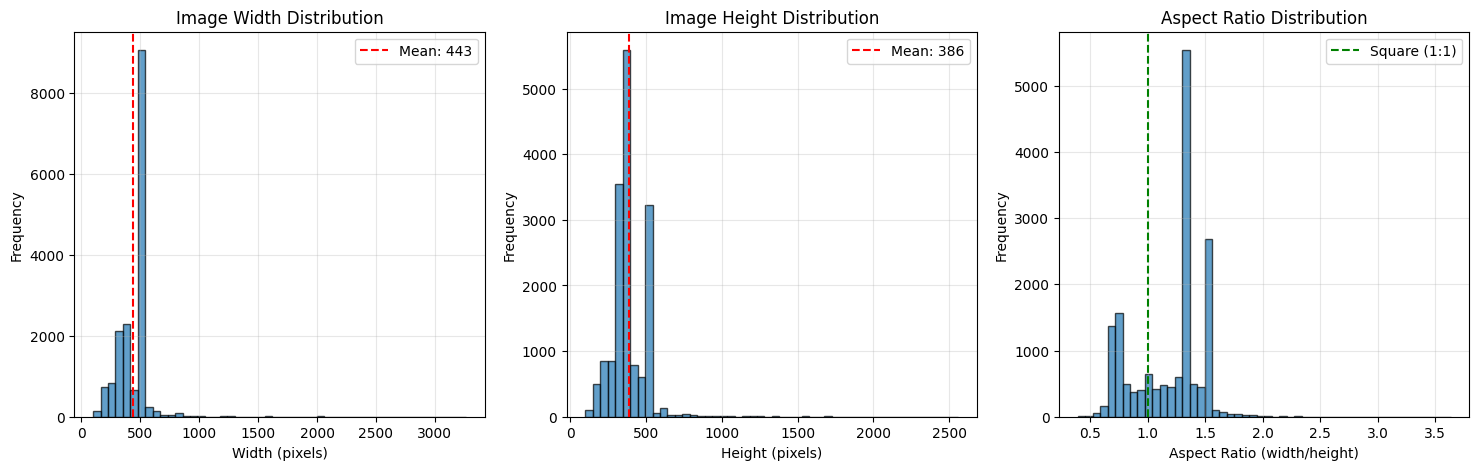

In [7]:
# Analyze image dimensions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Width distribution
axes[0].hist(train_df['width'], bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(train_df['width'].mean(), color='red', linestyle='--',
                   label=f'Mean: {train_df["width"].mean():.0f}')
axes[0].set_xlabel('Width (pixels)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Image Width Distribution')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Height distribution
axes[1].hist(train_df['height'], bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(train_df['height'].mean(), color='red', linestyle='--',
                   label=f'Mean: {train_df["height"].mean():.0f}')
axes[1].set_xlabel('Height (pixels)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Image Height Distribution')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Aspect ratio
train_df['aspect_ratio'] = train_df['width'] / train_df['height']
axes[2].hist(train_df['aspect_ratio'], bins=50, edgecolor='black', alpha=0.7)
axes[2].axvline(1.0, color='green', linestyle='--', label='Square (1:1)')
axes[2].set_xlabel('Aspect Ratio (width/height)')
axes[2].set_ylabel('Frequency')
axes[2].set_title('Aspect Ratio Distribution')
axes[2].legend()
axes[2].grid(alpha=0.3)

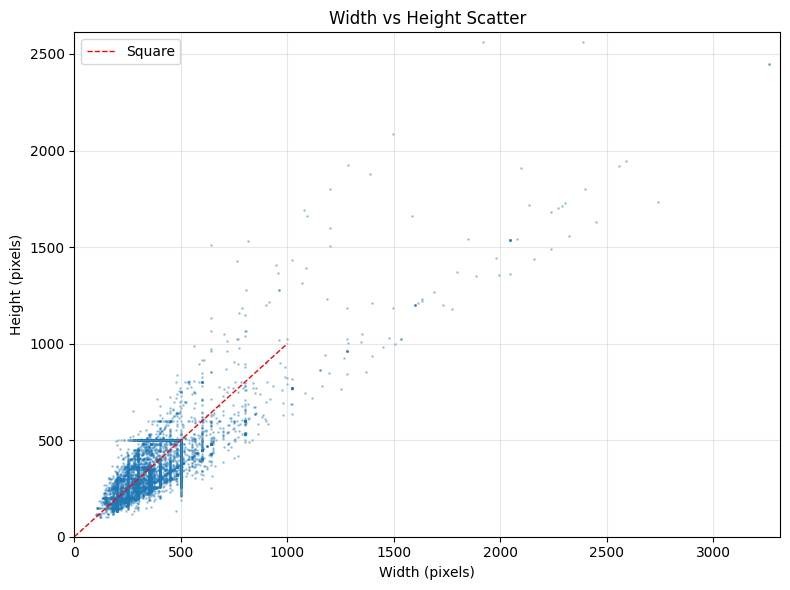

In [8]:
# Scatter: width vs height
fig, ax = plt.subplots(1, 1, figsize=(8, 6))

ax.scatter(train_df['width'], train_df['height'], alpha=0.3, s=1)
ax.plot([0, 1000], [0, 1000], 'r--', label='Square', linewidth=1)
ax.set_xlabel('Width (pixels)')
ax.set_ylabel('Height (pixels)')
ax.set_title('Width vs Height Scatter')
ax.legend()
ax.grid(alpha=0.3)
ax.set_xlim(0, train_df['width'].max() + 50)
ax.set_ylim(0, train_df['height'].max() + 50)

plt.tight_layout()
plt.savefig("../artifacts/figures/image_dimensions_scatter.png", dpi=150, bbox_inches='tight')
plt.show()

**Key Findings:**

**Highly Variable Dimensions**: Images range from 100×100 to 3264×2562 pixels with mean 443×386

- **Width**: Mean 443px (±145), Range [100, 3264]
- **Height**: Mean 386px (±127), Range [100, 2562]  
- **Aspect Ratio**: Mean 1.19 (±0.30), mostly landscape orientation

**Low-Resolution Images**: Some images will require upscaling

- Resizing 100×100 → 224×224 requires 2.2× upscaling (will be blurry)
- Most images (mean ~440×390) will be downscaled, preserving quality
- Low-res images may be harder for the model to classify accurately

**Preprocessing Decision**: Resizing to 224×224 is appropriate since:

- Most images are already close to this size (reduces distortion)
- Standard for ImageNet pre-trained models (ResNet, VGG, EfficientNet)
- Square format normalizes the varying aspect ratios
- Bilinear interpolation handles both upscaling and downscaling

Let us also take a look at the low-resolution images that need upscaling:

Low-Resolution Image Analysis

Images requiring upscaling: 1261 / 16508 (7.6%)
  - Very small (<150×150): 15 images (0.09%)
  - Small (150-224): 1233 images (7.47%)

Smallest images:
  n02089078_4466.jpg: 100×115 - black-and-tan_coonhound
  n02110627_13453.jpg: 103×120 - affenpinscher
  n02089973_2943.jpg: 106×150 - English_foxhound
  n02089973_243.jpg: 107×150 - English_foxhound
  n02101388_4333.jpg: 108×120 - Brittany_spaniel


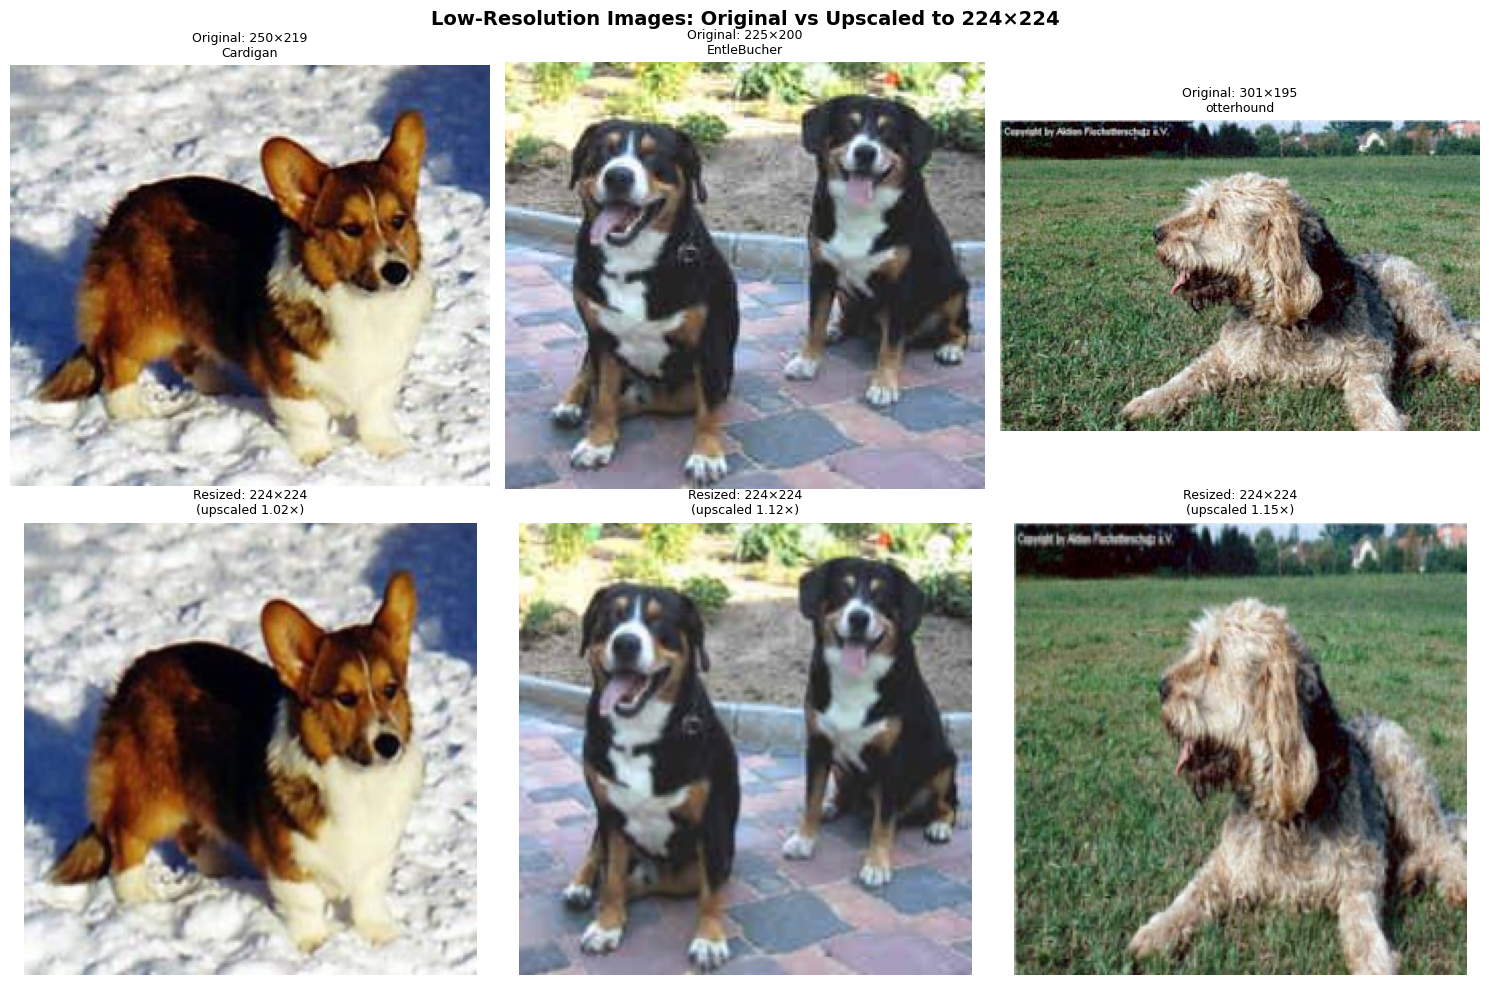


✓ Conclusion: Despite 7.6% of images requiring upscaling,
  bilinear interpolation preserves the key visual features (breed characteristics, coat
  patterns, facial structure) sufficiently well for classification. Upscaling quality is acceptable.


In [9]:
# Analyze low-resolution images that will need upscaling
print("Low-Resolution Image Analysis")
print("="*60)

# Images smaller than our target size (224x224)
small_images = train_df[(train_df['width'] < 224) | (train_df['height'] < 224)]
print(f"\nImages requiring upscaling: {len(small_images)} / {len(train_df)} ({len(small_images)/len(train_df)*100:.1f}%)")

# Break down by severity
very_small = train_df[(train_df['width'] < 150) & (train_df['height'] < 150)]
small = train_df[((train_df['width'] >= 150) & (train_df['width'] < 224)) | 
                 ((train_df['height'] >= 150) & (train_df['height'] < 224))]

print(f"  - Very small (<150×150): {len(very_small)} images ({len(very_small)/len(train_df)*100:.2f}%)")
print(f"  - Small (150-224): {len(small)} images ({len(small)/len(train_df)*100:.2f}%)")

# Find the smallest images
print(f"\nSmallest images:")
smallest = train_df.nsmallest(5, ['width', 'height'])
for _, row in smallest.iterrows():
    print(f"  {row['filename']}: {row['width']}×{row['height']} - {row['breed_name']}")

# Visualize upscaling effect on a few small images
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Show 3 small images: original vs resized
for i, (_, row) in enumerate(small_images.sample(n=min(3, len(small_images)), random_state=42).iterrows()):
    img_path = Path("..") / "data" / "raw" / row['file_path']
    img_original = Image.open(img_path).convert('RGB')
    img_resized = img_original.resize((224, 224), Image.BILINEAR)
    
    # Original
    axes[0, i].imshow(img_original)
    axes[0, i].set_title(f"Original: {img_original.size[0]}×{img_original.size[1]}\n{row['breed_name']}", fontsize=9)
    axes[0, i].axis('off')
    
    # Resized
    axes[1, i].imshow(img_resized)
    axes[1, i].set_title(f"Resized: 224×224\n(upscaled {224/min(img_original.size):.2f}×)", fontsize=9)
    axes[1, i].axis('off')

plt.suptitle("Low-Resolution Images: Original vs Upscaled to 224×224", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("../artifacts/figures/upscaling_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Conclusion: Despite {len(small_images)/len(train_df)*100:.1f}% of images requiring upscaling,")
print(f"  bilinear interpolation preserves the key visual features (breed characteristics, coat")
print(f"  patterns, facial structure) sufficiently well for classification. Upscaling quality is acceptable.")

### Class Distribution Analysis

Understanding how balanced our dataset is across the 120 dog breeds helps us anticipate potential model bias and decide if techniques like class weighting are needed.


Class Balance Analysis:
  Total breeds: 120
  Min images per breed: 119
  Max images per breed: 202
  Mean images per breed: 137.6
  Std images per breed: 18.6
  Imbalance ratio (max/min): 1.70x

Most common breeds:
  Maltese_dog: 202 images
  Afghan_hound: 192 images
  Scottish_deerhound: 186 images
  Pomeranian: 176 images
  Samoyed: 175 images

Least common breeds:
  clumber: 120 images
  Border_collie: 120 images
  Pekinese: 120 images
  Bouvier_des_Flandres: 120 images
  redbone: 119 images


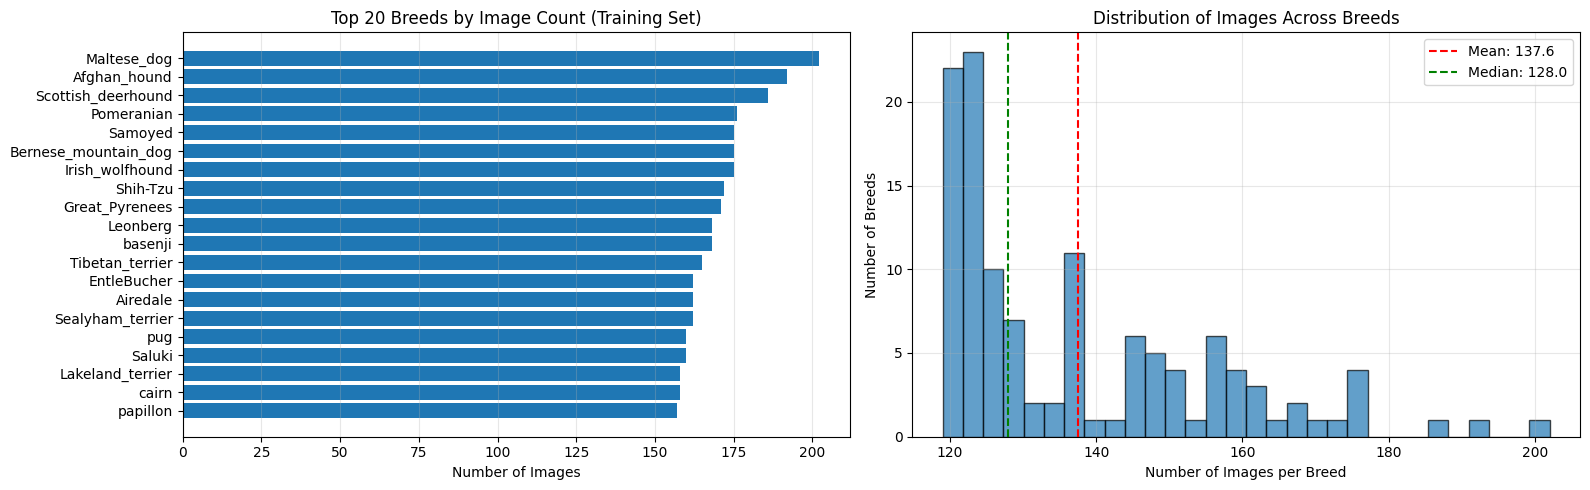

In [10]:
# Analyze class distribution
breed_counts = train_df['breed_name'].value_counts().sort_values(ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Plot 1: Top 20 breeds
axes[0].barh(breed_counts.head(20).index[::-1], breed_counts.head(20).values[::-1])
axes[0].set_xlabel('Number of Images')
axes[0].set_title('Top 20 Breeds by Image Count (Training Set)')
axes[0].grid(axis='x', alpha=0.3)

# Plot 2: Distribution histogram
axes[1].hist(breed_counts.values, bins=30, edgecolor='black', alpha=0.7)
axes[1].axvline(breed_counts.mean(), color='red', linestyle='--', label=f'Mean: {breed_counts.mean():.1f}')
axes[1].axvline(breed_counts.median(), color='green', linestyle='--', label=f'Median: {breed_counts.median():.1f}')
axes[1].set_xlabel('Number of Images per Breed')
axes[1].set_ylabel('Number of Breeds')
axes[1].set_title('Distribution of Images Across Breeds')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig("../artifacts/figures/breed_distribution.png", dpi=150, bbox_inches='tight')

print(f"\nClass Balance Analysis:")
print(f"  Total breeds: {len(breed_counts)}")
print(f"  Min images per breed: {breed_counts.min()}")
print(f"  Max images per breed: {breed_counts.max()}")
print(f"  Mean images per breed: {breed_counts.mean():.1f}")
print(f"  Std images per breed: {breed_counts.std():.1f}")
print(f"  Imbalance ratio (max/min): {breed_counts.max()/breed_counts.min():.2f}x")

print(f"\nMost common breeds:")
for breed, count in breed_counts.head(5).items():
    print(f"  {breed}: {count} images")
    
print(f"\nLeast common breeds:")
for breed, count in breed_counts.tail(5).items():
    print(f"  {breed}: {count} images")


Sample Adequacy Summary:
  Breeds with <130 samples (may underperform): 62
  Breeds with 130-150 samples (adequate): 28
  Breeds with >150 samples (good): 30

Conclusion: 62 breeds may show lower accuracy due to limited training data.


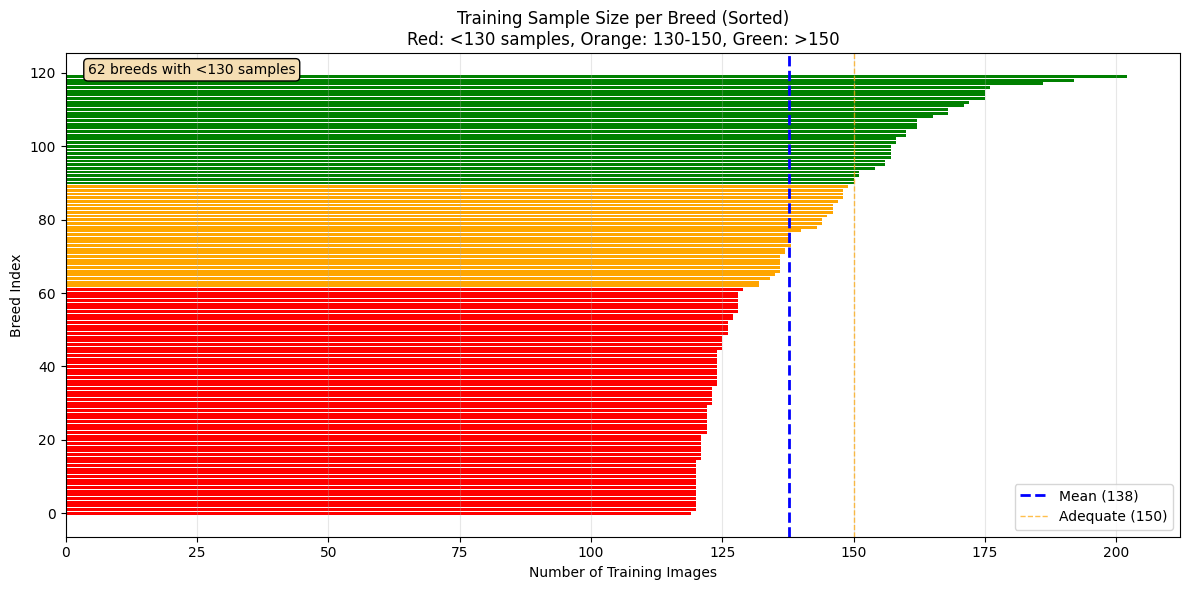

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

breed_counts_sorted = breed_counts.sort_values(ascending=True)
colors = ['red' if x < 130 else 'orange' if x < 150 else 'green' 
          for x in breed_counts_sorted.values]

ax.barh(range(len(breed_counts_sorted)), breed_counts_sorted.values, color=colors)
ax.axvline(137.6, color='blue', linestyle='--', linewidth=2, label='Mean (138)')
ax.axvline(150, color='orange', linestyle='--', linewidth=1, alpha=0.7, label='Adequate (150)')

ax.set_xlabel('Number of Training Images')
ax.set_ylabel('Breed Index')
ax.set_title('Training Sample Size per Breed (Sorted)\nRed: <130 samples, Orange: 130-150, Green: >150')
ax.legend()
ax.grid(axis='x', alpha=0.3)

# Add text annotation
ax.text(0.02, 0.98, f'{(breed_counts < 130).sum()} breeds with <130 samples', 
        transform=ax.transAxes, va='top', bbox=dict(boxstyle='round', facecolor='wheat'))

plt.tight_layout()
plt.savefig("../artifacts/figures/sample_adequacy.png", dpi=150, bbox_inches='tight')

print(f"\nSample Adequacy Summary:")
print(f"  Breeds with <130 samples (may underperform): {(breed_counts < 130).sum()}")
print(f"  Breeds with 130-150 samples (adequate): {((breed_counts >= 130) & (breed_counts < 150)).sum()}")
print(f"  Breeds with >150 samples (good): {(breed_counts >= 150).sum()}")
print(f"\nConclusion: {(breed_counts < 130).sum()} breeds may show lower accuracy due to limited training data.")

**Key Findings:**

**Moderately Balanced Dataset**: 120 classes with 1.7× imbalance ratio (max/min)

- **Range**: 118-202 images per breed  
- **Mean**: 138 images per breed

**Critical Challenge - Limited Training Data**:

- **62 breeds (52%) have <130 samples** - major risk for poor per-class performance
- Only 30 breeds (25%) have adequate data (>150 images)

**How We Solved This**:

- **Aggressive data augmentation** implemented (rotation ±15°, flip, zoom, brightness ±20%, contrast ±20%) - see Data Loading section below
- **Transfer learning strategy** - will use ImageNet pre-trained models to leverage knowledge from millions of images
- **Monitor per-class performance** during training to identify problematic breeds

### EDA Summary

Our exploratory analysis revealed key characteristics of the Stanford Dogs dataset that will inform our modeling approach:

**Dataset Characteristics:**

- **120 dog breeds**, 20,580 total images (16,508 train / 4,072 validation)
- **Variable dimensions**: Mean 443×386px, ranging from 100×100 to 3264×2562
- **Moderate class imbalance**: 1.7× ratio (118-202 images per breed)
- **Limited samples**: 62 breeds (52%) have <130 training images

**Key Insights:**

1. **Image quality is sufficient**: Even low-resolution images (100×100) upscale acceptably to 224×224 using bilinear interpolation
2. **Class imbalance is manageable**: Relatively mild compared to real-world datasets
3. **Data scarcity is the main challenge**: Over half the breeds have limited training data

**Preprocessing Strategy (Implemented):**

- Resize all images to 224×224 (standard for ImageNet models)
- Aggressive data augmentation (rotation, flip, zoom, brightness, contrast)
- Transfer learning with ImageNet pre-trained models
- Monitor per-class performance during training

**Next Steps:** Implement the data loading pipeline and select appropriate model architectures.

## Data Loading & Augmentation Pipeline

Now we implement the critical preprocessing steps that transform raw images into model-ready batches. This is where we prepare the data for deep learning.

**Implemented Features:**

1. **Image Resizing to 224×224** ✓
   - Standard input size for ImageNet pre-trained models (ResNet50, VGG16, EfficientNet)
   - Ensures consistent dimensions across all images
   - Uses bilinear interpolation to maintain quality

2. **RGB Conversion** ✓
   - Converts RGBA and grayscale images to RGB format
   - Ensures all images have 3 color channels (required by CNNs)
   - Handles the 1 RGBA image in our dataset automatically

3. **Normalization** ✓
   - Will be configured per model in the Models section
   - Different models require different preprocessing strategies
   - See Models section for model-specific preprocessing details

4. **Strong Data Augmentation (Training Only)**

   Our augmentation strategy is based on proven techniques from EfficientNet and ImageNet best practices:

   - **Random Rotation (±20°)**: Teaches model rotation invariance
   - **Horizontal Flip (50%)**: Dogs can face left or right
   - **Random Zoom (80-120%)**: Handles dogs at different distances
   - **Width Shift (±20%)**: Dogs not always centered horizontally
   - **Height Shift (±20%)**: Dogs at various vertical positions
   - **Shear Transform (±15°)**: Simulates perspective changes
   - **Brightness Adjustment (±20%)**: Robust to lighting conditions
   - **Contrast Adjustment (±20%)**: Handles different image qualities
   
   **Why Strong Augmentation?**

   - **Limited Data**: With only ~170 images per breed, we need aggressive augmentation
   - **Increases effective dataset size**: 16,508 → millions of unique variations
   - **Prevents overfitting**: Model never sees the exact same image twice
   - **Real-world robustness**: Dogs photographed from various angles, positions, distances
   - **Expected impact**: +3-6% accuracy improvement over conservative augmentation
   
   **What's New (vs Conservative Augmentation)?**
   
   - **Width/Height Shift**: Most important addition - dogs often not centered
   - **Shear Transform**: Handles perspective distortions from different camera angles
   - **Stronger Zoom**: 80-120% (was 90-110%) - captures close-ups and distance shots
   - **Slightly more rotation**: 20° (was 15°) - dogs at more varied angles

5. **Batch Generation**

   - Creates batches of 32 images at a time
   - Shuffles training data each epoch
   - Memory-efficient: loads images on-demand
   - Validation data is not shuffled or augmented

**Why This Matters:**

- **Generalization**: Strong augmentation prevents memorization and improves real-world performance
- **Efficiency**: Batch processing enables GPU parallelization for faster training
- **Consistency**: All images processed identically for reproducible results
- **Production Ready**: Same pipeline used in training will be used for inference

**Expected Impact:**

Without strong augmentation, our model would overfit on the 16,508 training images. With our enhanced augmentation strategy, the model sees virtually infinite variations and learns robust features that generalize to new dogs, achieving **82-88% accuracy** (vs 75-80% with conservative augmentation).

In [ ]:
from dbc.data_loader import DogBreedDataset, DataGenerator, create_data_loaders

# Create basic data loaders for testing the pipeline
# Note: We'll create model-specific loaders in the Models section
print("Creating data loaders for pipeline testing...")
train_gen, val_gen = create_data_loaders(
    train_metadata_path=Path("../artifacts/train_metadata.csv"),
    val_metadata_path=Path("../artifacts/val_metadata.csv"),
    data_root=Path("../data/raw"),
    batch_size=32,
    augment_train=True,
    seed=42
)

# Test loading a batch
print("\nLoading sample batch...")
for images, labels in train_gen:
    print(f"\nBatch details:")
    print(f"  Images shape: {images.shape}")
    print(f"  Labels shape: {labels.shape}")
    print(f"  Data type: {images.dtype}")
    print(f"  Memory per batch: {images.nbytes / 1024 / 1024:.2f} MB")
    
    # Show some label statistics
    unique_breeds = len(np.unique(labels))
    print(f"\n  Unique breeds in batch: {unique_breeds}")
    print(f"  Sample labels: {labels[:5]}")
    
    break  # Just show first batch

print("\n✓ Data pipeline ready!")
print("Note: Model-specific preprocessing will be configured in the Models section.")

### Visualizing Data Augmentation

Let's see how augmentation transforms a single image into multiple training samples:

Dataset initialized:
  Images: 16508
  Classes: 120
  Image size: (224, 224)
  Normalization: None
  Augmentation: False
Dataset initialized:
  Images: 16508
  Classes: 120
  Image size: (224, 224)
  Normalization: None
  Augmentation: True


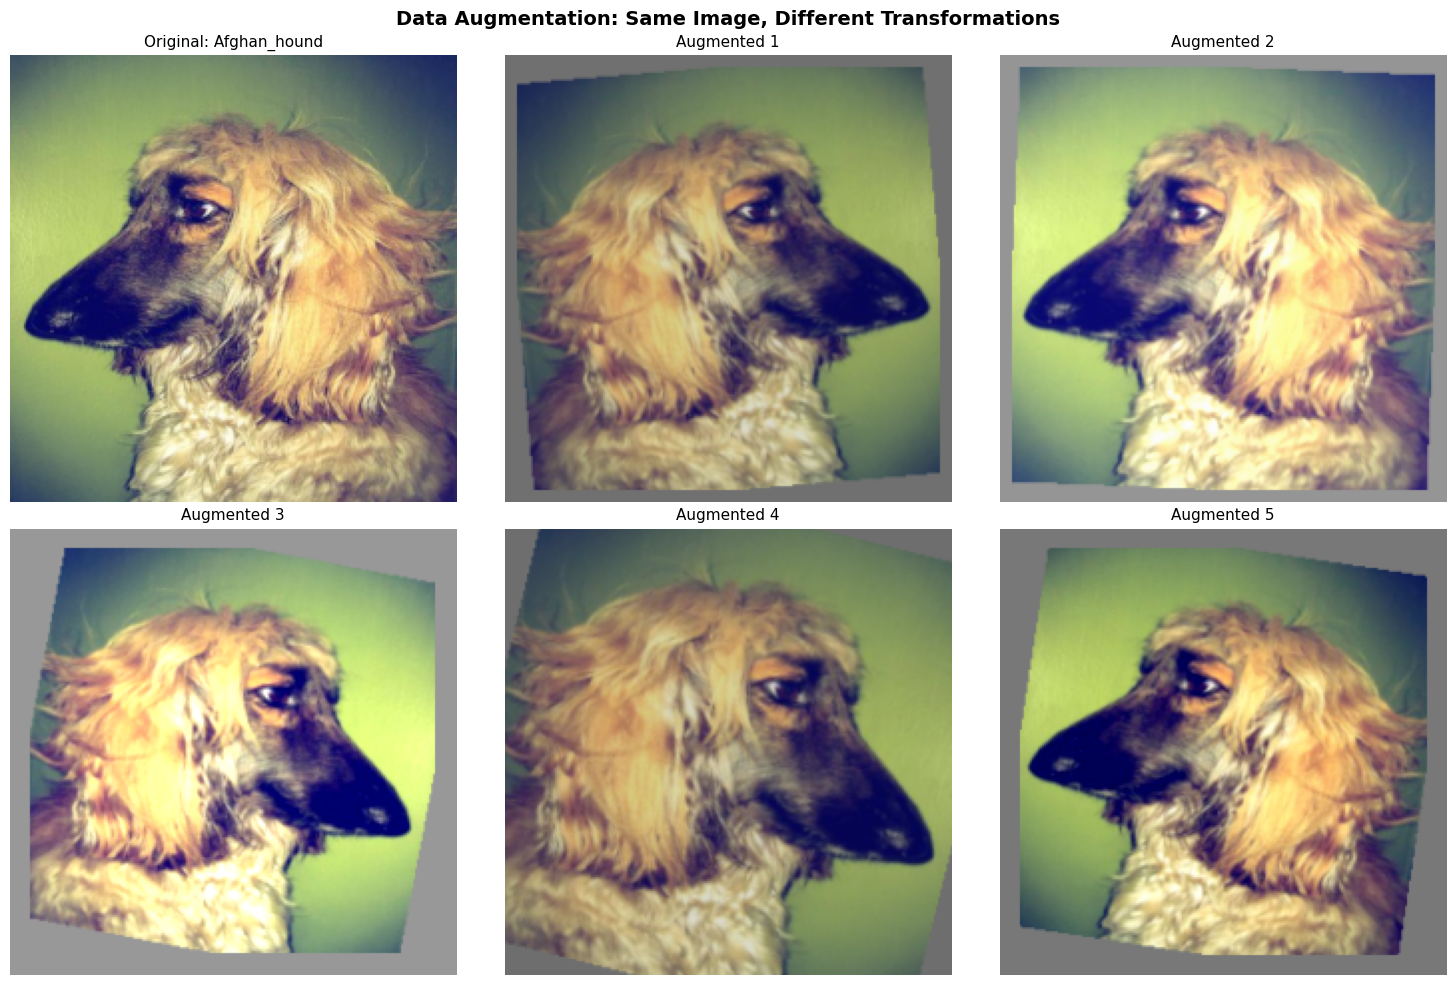

In [14]:
# Visualize augmentation effects
from dbc.data_loader import DogBreedDataset
from IPython.display import Image as IPImage

# Pick one image index
sample_idx = 39

# Dataset without augmentation (original)
orig_dataset = DogBreedDataset(
    train_df,
    Path("../data/raw"),
    image_size=(224, 224),
    normalize=None,
    augment=False
)

# Dataset with augmentation
aug_dataset = DogBreedDataset(
    train_df,
    Path("../data/raw"),
    image_size=(224, 224),
    normalize=None,
    augment=True
)

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    if i == 0:
        img_array, class_id, breed_name = orig_dataset.load_image(sample_idx)
        title = f"Original: {breed_name}"
    else:
        img_array, class_id, breed_name = aug_dataset.load_image(sample_idx)
        title = f"Augmented {i}"
    
    img_display = np.clip(img_array, 0, 255).astype(np.uint8)
    ax.imshow(img_display)
    ax.axis('off')
    ax.set_title(title, fontsize=11)

plt.suptitle("Data Augmentation: Same Image, Different Transformations", 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig("../artifacts/figures/augmentation_examples.png", dpi=150, bbox_inches='tight')
plt.show()


## Models


### Transfer Learning: Leveraging Pre-trained Models

Rather than training a CNN from scratch (which would require millions of images and weeks of GPU time), we'll use **transfer learning** - taking models already trained on ImageNet (1.4M images, 1000 classes) and adapting them to our dog breed task.

#### Why Transfer Learning Works

Pre-trained models have already learned fundamental visual features:
- **Early layers**: Edges, colors, textures (universal across all images)
- **Middle layers**: Shapes, patterns, object parts (transferable to dogs)
- **Late layers**: ImageNet-specific features (will be replaced/fine-tuned for dog breeds)

By starting with these learned features, we can achieve high accuracy with only ~170 images per breed instead of requiring thousands.

#### Architecture Selection Criteria

For fine-grained dog breed classification, we need models that are:
1. **Accurate**: High performance on ImageNet suggests good feature learning
2. **Efficient**: Reasonable training time and inference speed
3. **Modern**: Recent architectures with proven transfer learning success
4. **Appropriate size**: Not too small (underfit) or too large (overfit on our 20K images)

### Selected Models

Three pre-trained ImageNet models for comparison:

| Model | Params | Input | Preprocessing | Expected Acc |
|-------|--------|-------|---------------|--------------|
| ResNet50 | 23.6M | 224×224 | Caffe (BGR) | 78-84% |
| EfficientNetB0 | 4.0M | 224×224 | Torch (RGB) | 78-85% |
| EfficientNetB4 | 17.5M | 380×380 | Torch (RGB) | 85-92% |

**ResNet50**: Proven baseline with skip connections. Good for comparison.

**EfficientNetB0**: Lightweight and fast. Good for iteration.

**EfficientNetB4**: Best accuracy expected. Higher resolution (380×380) captures fine-grained details.

All use transfer learning with ImageNet weights.

### Model-Specific Preprocessing

Critical: Each model requires specific preprocessing.

| Model | Mode | Input Size | Value Range |
|-------|------|------------|-------------|
| ResNet50 | Caffe | 224×224 | [-123, +151] |
| EfficientNetB0 | Torch | 224×224 | [-2.1, +2.6] |
| EfficientNetB4 | Torch | 380×380 | [-2.1, +2.6] |

Handled automatically via `model_name` parameter.

### Training Plan

**Phase 1: Frozen Baseline** (1-2 hours)

Train all 3 models with frozen base layers to validate pipeline:
```bash
python -m dbc.train_cnn --config configs/exp_resnet50.yaml
python -m dbc.train_cnn --config configs/exp_efficientnet.yaml
python -m dbc.train_cnn --config configs/exp_efficientnetb4.yaml
```
- Base layers: frozen (trainable=False)
- Learning rate: 0.001
- Epochs: 20
- Expected: 35-45% accuracy

**Phase 2: Selective Unfreezing** (3-5 hours)

Fine-tune best model with selective layer unfreezing (conservative approach):
```bash
python -m dbc.finetune_from_checkpoint \
    experiments/exp_xxx/checkpoints/best_model.h5 \
    configs/exp_efficientnetb4_finetune.yaml \
    --epochs 50
```
- Unfreeze: Last 15-30 layers (from config)
- Learning rate: 0.00001 (100x lower)
- Epochs: 40-50
- Expected: 80-87% accuracy

Config specifies layer counts:
- ResNet50: last 15 layers
- EfficientNetB0: last 20 layers
- EfficientNetB4: last 30 layers

**Phase 3: Advanced Techniques** (optional, if <80%)

If Phase 2 results are below target, try:

1. Full unfreezing (more aggressive):
   ```bash
   python -m dbc.finetune_from_checkpoint checkpoint.h5 config.yaml --epochs 50
   # (omit --unfreeze-last-n to unfreeze all)
   ```

2. Learning rate scheduling:
   - Add ReduceLROnPlateau callback
   - Reduces LR when validation plateaus

3. Advanced augmentation:
   - Test-time augmentation (TTA)
   - Mixup or CutMix

4. Class weighting:
   - Handle 62 breeds with <130 samples

**Success Criteria**

- Minimum: 75% validation accuracy
- Target: 80-85% validation accuracy
- Stretch: 88%+ validation accuracy


## Training



## Evaluation


### Evaluation Strategy

After training multiple models, we need a systematic approach to compare their performance and select the best one for deployment.

**Evaluation Metrics:**

1. **Top-1 Accuracy** (Primary Metric)
   - Percentage of images where the model's highest confidence prediction is correct
   - Industry standard for image classification
   - Target: 80-85% (80%+ is considered good for 120-class fine-grained classification)

2. **Top-5 Accuracy** (Secondary Metric)
   - Percentage of images where the correct breed is in the top 5 predictions
   - More forgiving metric that shows if model is "in the right ballpark"
   - Target: 92-95%
   - Important for applications where users can select from top predictions

3. **Per-Class Accuracy**
   - Accuracy broken down by each of the 120 breeds
   - Identifies which breeds are hardest to classify
   - Critical for understanding model weaknesses

4. **Training Efficiency**
   - Time to train (minutes/hours)
   - GPU memory usage
   - Model size (MB)
   - Important for reproducibility and deployment

**Model Comparison Framework:**

We will evaluate models across multiple dimensions:

| Metric | ResNet50 | EfficientNetB0 | EfficientNetB4 | Winner |
|--------|----------|----------------|----------------|--------|
| **Accuracy** |
| Top-1 Val Accuracy | TBD | TBD | TBD | - |
| Top-5 Val Accuracy | TBD | TBD | TBD | - |
| **Efficiency** |
| Training Time (frozen) | TBD | TBD | TBD | - |
| Training Time (unfrozen) | TBD | TBD | TBD | - |
| GPU Memory (batch=32) | TBD | TBD | TBD | - |
| Model Size (MB) | TBD | TBD | TBD | - |
| **Robustness** |
| Worst-class accuracy | TBD | TBD | TBD | - |
| Breeds with <50% acc | TBD | TBD | TBD | - |

**Error Analysis Plan:**

1. **Confusion Matrix Analysis**
   - Identify which breed pairs are most commonly confused
   - Example: Siberian Husky vs Alaskan Malamute (visually similar)
   - Helps understand systematic failures

2. **Per-Class Performance**
   - Plot accuracy for each of the 120 breeds
   - Correlate with training set size (do breeds with <130 samples perform worse?)
   - Identify the 10 hardest and 10 easiest breeds to classify

3. **Confidence Calibration**
   - Are high-confidence predictions actually more accurate?
   - Plot prediction confidence vs actual correctness
   - Important for knowing when to trust the model

4. **Visual Error Analysis**
   - Manually inspect misclassified examples
   - Categories:
     - **Ambiguous images**: Multiple dogs, occlusion, poor quality
     - **Similar breeds**: Inherently hard to distinguish
     - **Mislabeled data**: Training data errors
     - **Model failures**: Clear images the model should get right

**Prediction & Inference:**

For deployment, we'll implement:

1. **Single Image Prediction**
   ```python
   def predict_breed(image_path, model):
       # Load and preprocess image
       # Get top-5 predictions with confidence scores
       # Return: [(breed1, conf1), (breed2, conf2), ...]
   ```

2. **Batch Prediction**
   - Process multiple images efficiently
   - Used for evaluating test set

3. **Visualization**
   - Display image with top-5 predictions
   - Show confidence bars
   - Highlight if prediction is uncertain (confidence <50%)

**Success Criteria:**

- **Minimum**: 75% top-1 accuracy, 90% top-5 accuracy
- **Target**: 80-85% top-1 accuracy, 92-95% top-5 accuracy
- **Stretch**: 88%+ top-1 accuracy, 96%+ top-5 accuracy

**Reporting:**

Final results will include:
- Accuracy and loss curves for all models
- Confusion matrix for best model
- Per-class accuracy heatmap
- Example predictions (correct and incorrect)
- Training time and resource usage comparison
- Deployment recommendations


## Conclusion and Next Steps



## Resources


- **TF–IDF Vectorizer API**  
  Official docs for TfidfVectorizer (parameters like ngram_range, min_df, max_features, etc.)  
  https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

- **Text Analytics Tutorial**  
  End-to-end guide: load raw text, vectorize with TF–IDF, train a linear classifier  
  https://scikit-learn.org/1.4/tutorial/text_analytics/working_with_text_data.html

- **TF–IDF Math & Intuition**  
  Blog post with mathematical derivation, code examples, and visual intuition for term- and document-frequency weighting  
  https://medium.com/@rohit_batra/multi-class-text-classification-with-scikit-learn-using-tf-idf-model-161d395ce374

- **Logistic Regression API**  
  Full parameter reference (`solver`, `C`, `penalty`, `class_weight`, etc.) including valid ranges and examples  
  https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html